<a href="https://colab.research.google.com/github/DavidMao0310/Prediction_Tesla_Stock_Price/blob/main/FYP_Midterm_Pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

--2021-01-05 12:35:17--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-05 12:35:18--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-05 12:35:18--  https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.so

In [2]:
url = 'https://github.com/DavidMao0310/LR-and-random-forest-for-prediction/raw/main/TSLA.csv'
data = pd.read_csv(url)
pd.set_option('display.max_columns', None)
print(data)
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data.set_index('Date', inplace=True)
data['1d_future_close'] = data['Adj_Close'].shift(-1)
data['1d_close_pct'] = data['Adj_Close'].pct_change(1)
data['Volume_1d_change'] = data['Volume'].pct_change(1)
feature_names = ['1d_close_pct', 'Volume_1d_change']
for n in [14, 30, 100]:
    data['sma' + str(n)] = ta.SMA(data['Adj_Close'].values, timeperiod=n)
    data['rsi' + str(n)] = ta.RSI(data['Adj_Close'].values, timeperiod=n)
    data['ema' + str(n)] = ta.EMA(data['Adj_Close'].values, timeperiod=n)
    data['std' + str(n)] = ta.STDDEV(data['Adj_Close'].values, timeperiod=n)
    feature_names = feature_names + ['sma' + str(n), 'rsi' + str(n), 'ema' + str(n), 'std' + str(n)]
data['ATR'] = ta.ATR(data['High'].values,
                     data['Low'].values,
                     data['Adj_Close'].values,
                     timeperiod=14)
data['ADX'] = ta.ADX(data['High'].values,
                     data['Low'].values,
                     data['Adj_Close'].values,
                     timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(data['Adj_Close'].values,
                                     fastperiod=12,
                                     slowperiod=26,
                                     signalperiod=9)
data['MACD'] = macd
data['MACDsignal'] = macdsignal
feature_names = feature_names + ['ATR', 'ADX', 'MACD', 'MACDsignal']
print(data)
data = data.dropna()


            Date       Open       High        Low      Close  Adj_Close  \
0       2015/1/2  44.574001  44.650002  42.652000  43.862000  43.862000   
1       2015/1/5  42.910000  43.299999  41.431999  42.018002  42.018002   
2       2015/1/6  42.012001  42.840000  40.841999  42.256001  42.256001   
3       2015/1/7  42.669998  42.956001  41.956001  42.189999  42.189999   
4       2015/1/8  42.562000  42.759998  42.001999  42.124001  42.124001   
...          ...        ...        ...        ...        ...        ...   
1252  2019/12/23  82.356003  84.402000  82.000000  83.844002  83.844002   
1253  2019/12/24  83.671997  85.094002  82.538002  85.050003  85.050003   
1254  2019/12/26  85.582001  86.695999  85.269997  86.188004  86.188004   
1255  2019/12/27  87.000000  87.061996  85.222000  86.075996  86.075996   
1256  2019/12/30  85.758003  85.800003  81.851997  82.940002  82.940002   

        Volume  
0     23822000  
1     26842500  
2     31309500  
3     14842000  
4     17212500

In [3]:
print(data)
features = data[feature_names]
targets = pd.DataFrame(data['1d_future_close'])###
train_size = int(0.8 * targets.shape[0])
train_features = features[:train_size]
train_features = pd.DataFrame(preprocessing.StandardScaler().fit_transform(train_features))
train_features.columns = feature_names
train_targets = targets[:train_size]
train_targets = train_targets.values.ravel()

test_features = features[train_size:]
test_features = pd.DataFrame(preprocessing.StandardScaler().fit_transform(test_features))
test_features.columns = feature_names
test_targets = targets[train_size:]
test_targets = test_targets.values.ravel()

print('Training Features Shape:', train_features.shape)
print('Training Targets Shape:', train_targets.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Targets Shape:', test_targets.shape, '\n')



                 Open       High        Low      Close  Adj_Close    Volume  \
Date                                                                          
2015-05-28  49.405998  50.360001  49.009998  50.290001  50.290001  18236500   
2015-05-29  50.200001  50.574001  49.886002  50.160000  50.160000  18946500   
2015-06-01  50.282001  50.320000  49.493999  49.889999  49.889999  12525500   
2015-06-02  49.784000  49.880001  49.259998  49.669998  49.669998  10674000   
2015-06-03  49.639999  50.144001  49.402000  49.798000  49.798000   8907500   
...               ...        ...        ...        ...        ...       ...   
2019-12-20  82.057999  82.599998  80.038002  81.117996  81.117996  73763500   
2019-12-23  82.356003  84.402000  82.000000  83.844002  83.844002  66598000   
2019-12-24  83.671997  85.094002  82.538002  85.050003  85.050003  40273500   
2019-12-26  85.582001  86.695999  85.269997  86.188004  86.188004  53169500   
2019-12-27  87.000000  87.061996  85.222000  86.0759

LR train 0.9792298699471064
LR test -4.479526179363276
intercept =  54.9899956926409 
 slope= [ 4.37886568e-01  8.08408076e-03  6.94661085e+00  1.14702397e+00
  2.45728851e+02  9.64663526e-02 -2.21418211e+00 -1.11900989e+00
 -2.42386561e+02  2.08440228e-01  4.54551717e+00  1.90384083e+00
  3.78495838e+00  2.51840683e-01 -5.19926421e-02 -2.33619098e-01
 -1.94332086e+01 -1.19785629e+01] 



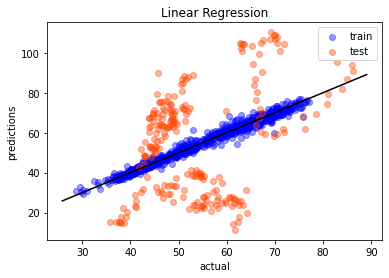

In [4]:
from sklearn import linear_model as lm
skmodel = lm.LinearRegression().fit(train_features,train_targets)
def LM(skmodel, train_features, train_targets ,test_features, test_targets):
    print('LR train', skmodel.score(train_features, train_targets))
    print('LR test', skmodel.score(test_features, test_targets))
    print('intercept = ', skmodel.intercept_, '\n', 'slope=', skmodel.coef_, '\n')
    train_predictions = skmodel.predict(train_features)
    test_predictions = skmodel.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train', alpha=0.4, color='b')
    plt.scatter(test_targets, test_predictions, label='test', alpha=0.4, color='orangered')
    #plt.scatter(targets, targets, label='Original', alpha=0.3, color='navajowhite')
    # Plot the perfect prediction line
    xmin, xmax = plt.xlim()
    plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title('Linear Regression')
    plt.legend()
    plt.show()
LM(skmodel,train_features, train_targets, test_features, test_targets)


DTR best depth 5
DTR train 0.9737800845757585
DTR test 0.7304136226701607 



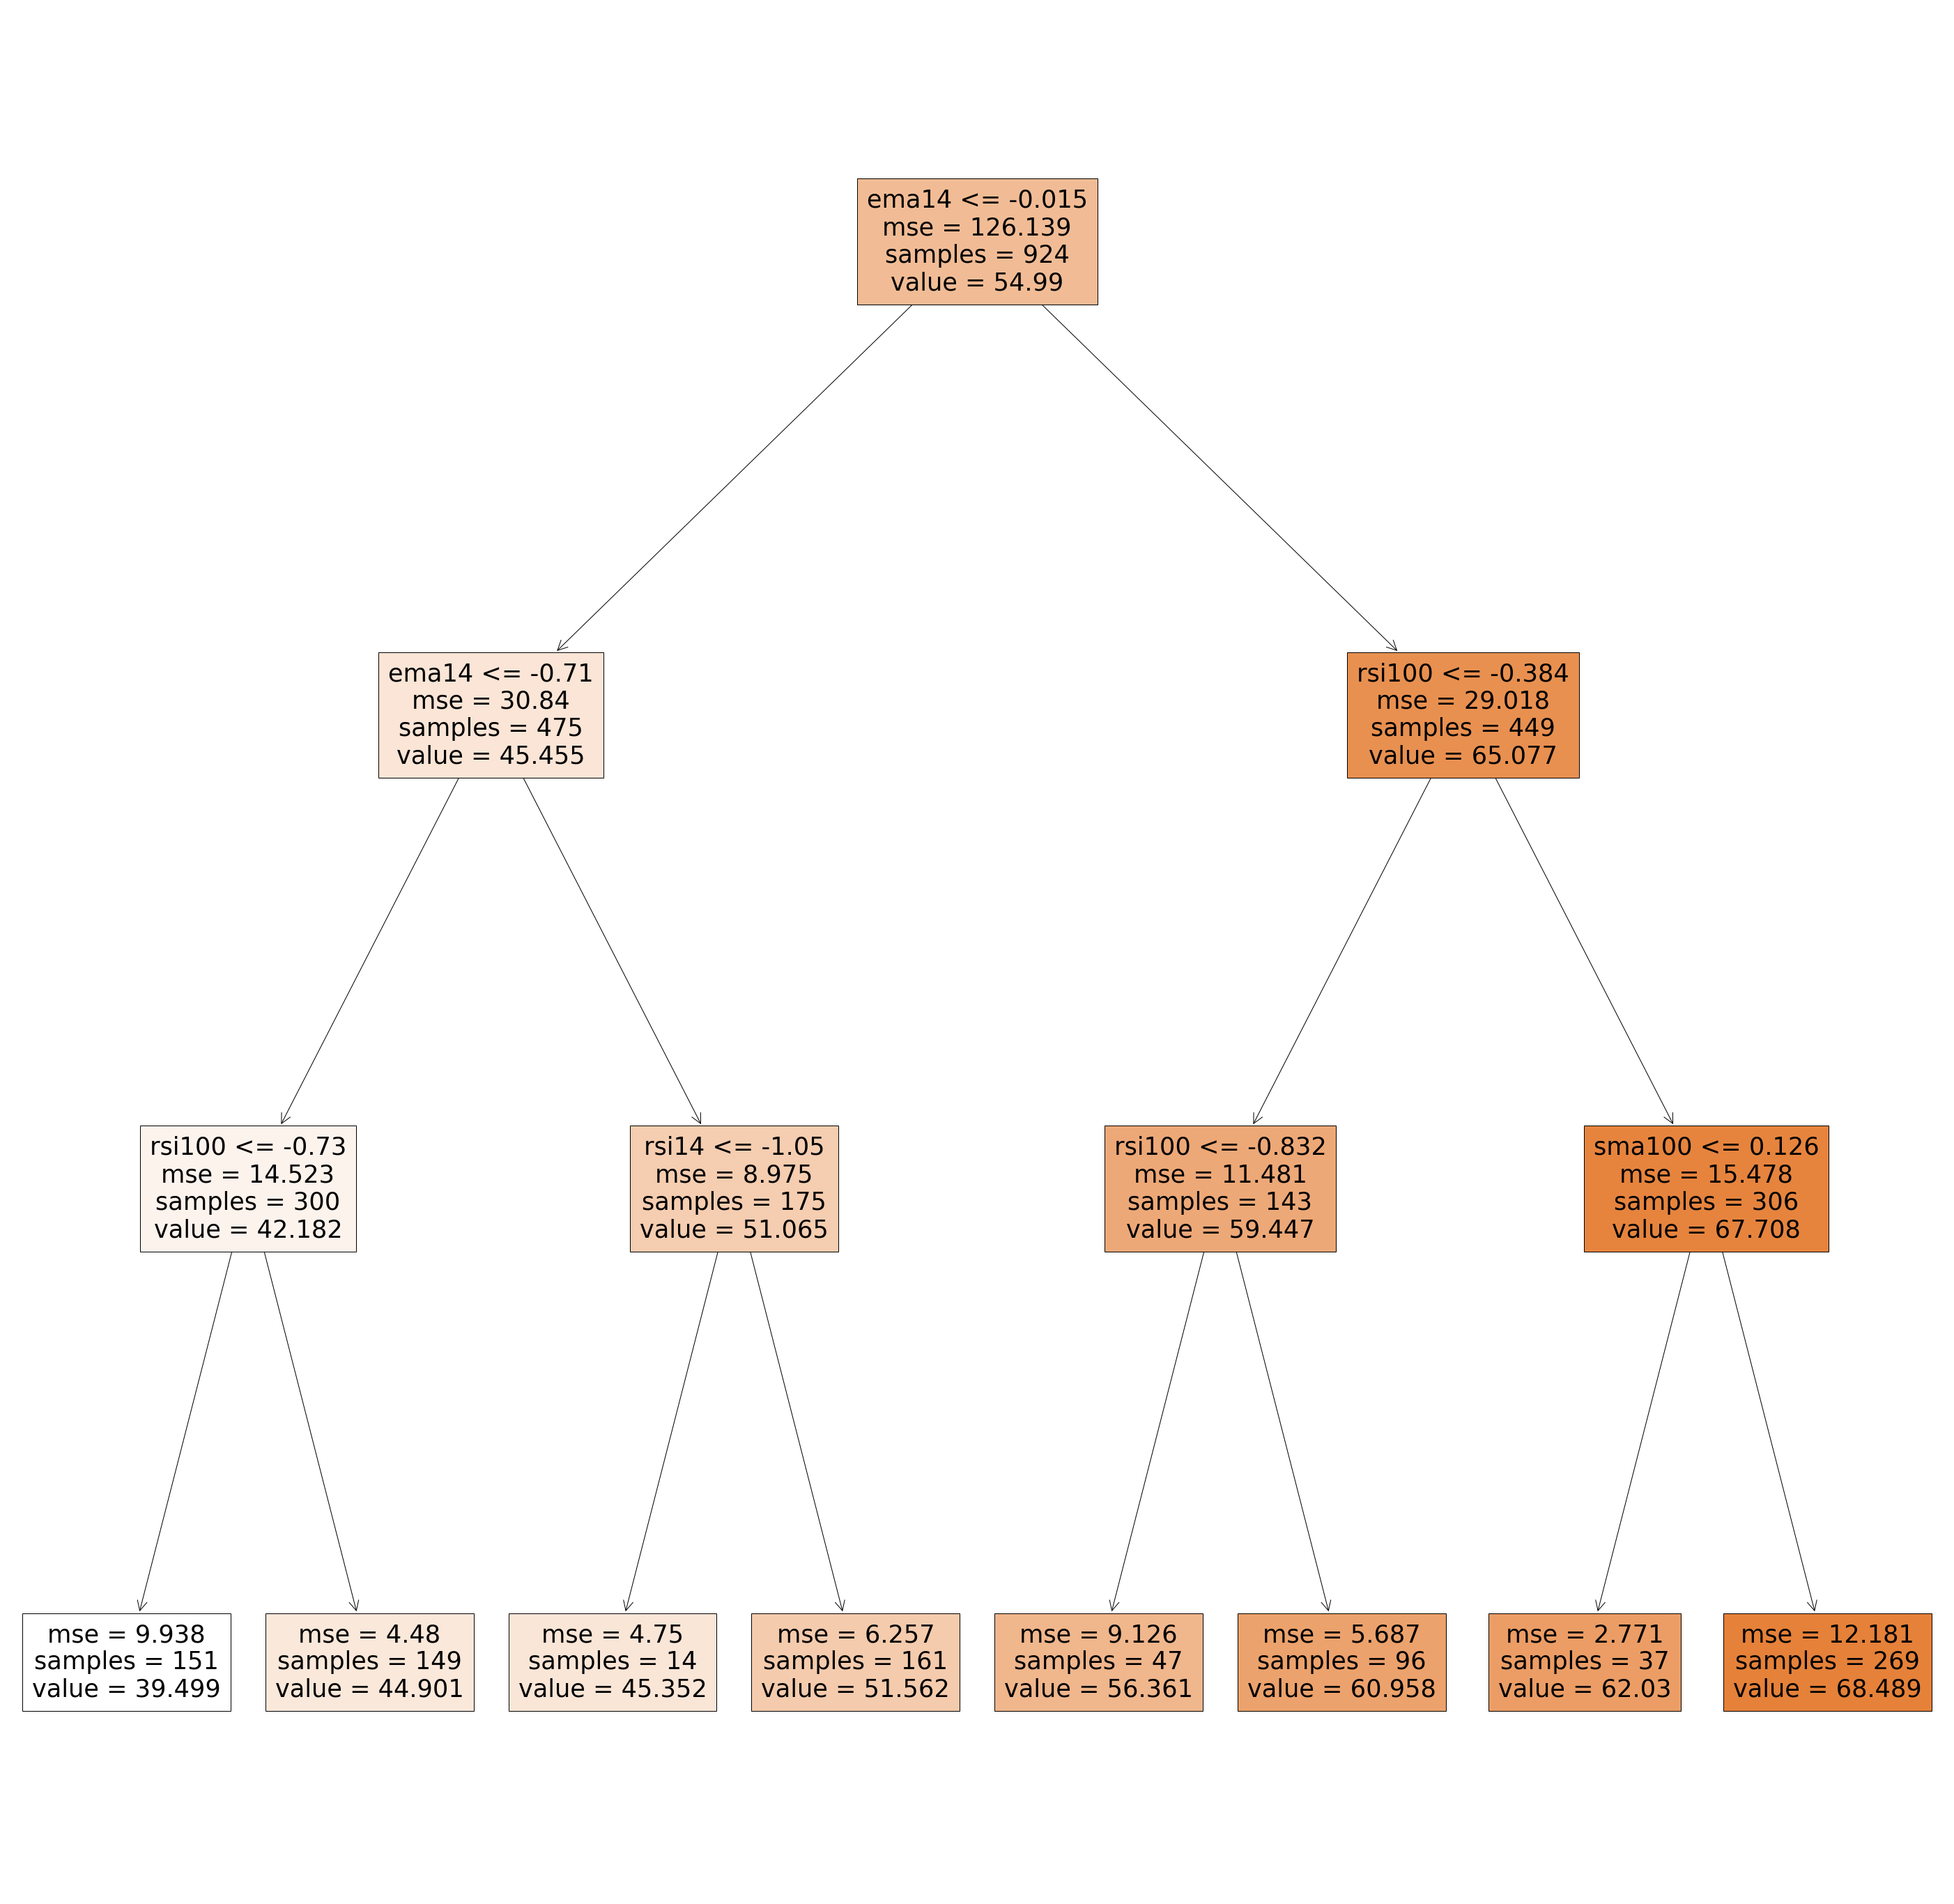

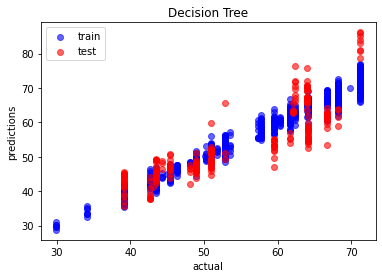

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
def DTR(train_features, train_targets, test_features, test_targets):
    score =[]
    for i in range(1, 10):
        decision_tree1 = DecisionTreeRegressor(max_depth=i)
        decision_tree1.fit(train_features, train_targets)
        score.append(decision_tree1.score(test_features, test_targets))
    print('DTR best depth', np.argmax(score)+1)       
    decision_tree = DecisionTreeRegressor(max_depth=np.argmax(score)+1)
    decision_tree.fit(train_features, train_targets)
    print('DTR train', decision_tree.score(train_features, train_targets))
    print('DTR test', decision_tree.score(test_features, test_targets), '\n')

    plt.figure(figsize=(50, 50))
    #plot tree with 3 depth
    tree.plot_tree(DecisionTreeRegressor(max_depth=3).fit(train_features, train_targets), 
                   filled=True, feature_names=feature_names)
    plt.show()
    train_predictions = decision_tree.predict(train_features)
    test_predictions = decision_tree.predict(test_features)
    # Scatter the predictions vs actual values
    plt.scatter(train_predictions, train_targets, label='train', alpha = 0.6, c='b')
    plt.scatter(test_predictions, test_targets, label='test', alpha = 0.6, c='r')
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title('Decision Tree')
    plt.legend()
    plt.show()
DTR(train_features, train_targets, test_features, test_targets)

RF best depth 7
RF train 0.9920386015199731
RF test 0.8085349591593932 



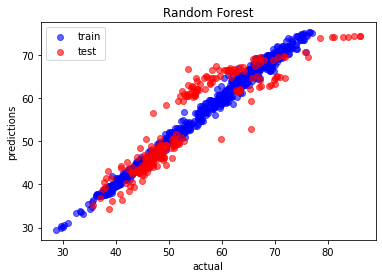

In [6]:
from sklearn.ensemble import RandomForestRegressor
def RF(train_features, train_targets, test_features, test_targets):
    score = []
    for i in range(1, 10):
        decision_tree1 = RandomForestRegressor(max_depth=i)
        decision_tree1.fit(train_features, train_targets)
        score.append(decision_tree1.score(test_features, test_targets))
    print('RF best depth', np.argmax(score)+1)
    rfr = RandomForestRegressor(n_estimators=400,
                                max_depth=np.argmax(score)+1,
                                random_state=42)
    rfr.fit(train_features, train_targets)
    # Look at the R^2 scores on train and test
    print('RF train', rfr.score(train_features, train_targets))
    print('RF test',rfr.score(test_features, test_targets), '\n')
    train_predictions = rfr.predict(train_features)
    test_predictions = rfr.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train', alpha = 0.6, c='b')
    plt.scatter(test_targets, test_predictions, label='test', alpha = 0.6, c='r')
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title('Random Forest')
    plt.legend()
    plt.show()
RF(train_features, train_targets, test_features, test_targets)

GBR best depth 1
GBR train 0.9819867530862991
GBR test 0.88193786371397 



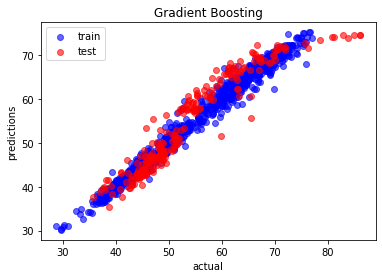

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
def GB(train_features, train_targets, test_features, test_targets):
    score = []
    for i in range(1, 10):
        score = []
        decision_tree1 = GradientBoostingRegressor(max_depth=i)
        decision_tree1.fit(train_features, train_targets)
        score.append(decision_tree1.score(test_features, test_targets))
    print('GBR best depth', np.argmax(score)+1)
    gbr = GradientBoostingRegressor(n_estimators=400,
                                    random_state=42,
                                    max_depth=np.argmax(score)+1
                                    )
    gbr.fit(train_features, train_targets)
    print('GBR train', gbr.score(train_features, train_targets))
    print('GBR test', gbr.score(test_features, test_targets), '\n')
    train_predictions = gbr.predict(train_features)
    test_predictions = gbr.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train', alpha = 0.6, c='b')
    plt.scatter(test_targets, test_predictions, label='test', alpha = 0.6, c='r')
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title('Gradient Boosting')
    plt.legend()
    plt.show()
GB(train_features, train_targets, test_features, test_targets)